In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from functools import reduce
from itertools import product
from tqdm.notebook import tqdm

from dataclasses import dataclass
from typing import List, Tuple

from collections import Counter

We will try to avoid implementing thigns with circuits, for maximal transparency, at the expense of speed.

Rerun this cell to reload latex commands.
$\newcommand{\C}{\mathbb{C}}$ $\def\Paren#1{\left( #1 \right)}$ $\def\Brack#1{\left[ #1 \right]}$ $\def\Set#1{\left\{ #1 \right\}}$ $\newcommand{\ket}[1]{\left|{#1}\right\rangle} \newcommand{\bra}[1]{\left\langle{#1}\right|}$ $\newcommand{\cS}{\mathcal{S}}$

Quantum computers are very noisy. Qubits change unexpectedly. In classical computers, there is a variety of methods to deal with this. Quantum compputing needs a quantum alternative to these methods, if we want the hardware to work. 

Common concepts:

* Logical space: This is the information that you want to represent, the idealized qubit. 
* Physical space: This is how qubits "actually" are. The noise affects these qubits. 

We hope to establish a mapping between the physical space and the logical space so that we can operate in the logical space despite errors affecting the physical space.

A new hope: Quantum Fault-Tolerance Theorem. If we can get quantum error correction below a threshold, we can compute indefinitely with that low error.

Operations in quantum comptuign are unitaries. These are generalized by quantum channels. In essense, a channel can 
be thought as a set of gates $U_1,\ldots, U_n$, and probabilities $p_1,\ldots, p_n$, such that gate $U_i$ is applied with probability $p_i$.

These maps are also called, for technical reasons, Completely Positive and Trace Preserving (CPTP) maps.

The common setup in the following situations is the following. You have some quantum information, which is encoded in 
some way. Then something happens to the state, and you must be able to recover the initial information. The nature of the "something" depends on the state. 

In stabilizer codes, "something" will mean a gate is randomly applied to the state. This includes the identity gate, which is the same as not doing anything. For the irrep and the AdS/CFT inspired code, this will mean a qubit disappearing.

Definition: An $[n,k]$ code is one that can encode $k$ logical qubits into $n$ physical qubits. An $[n,k,d]$ coode is one that can encode $k$ logical qubits into $n$ physical qubits so that the distance between two codes is at least $3$. This means that modifying any (known) $d-1$ of the qubits do not lead to ambiguity.

# Stabilizer Codes


[Stabilizer Codes and Quantum Error Correction](https://arxiv.org/abs/quant-ph/9705052)


$\def\Paren#1{\left( #1 \right)}$ $\def\Brack#1{\left[ #1 \right]}$ $\def\Set#1{\left\{ #1 \right\}}$ $\newcommand{\ket}[1]{\left|{#1}\right\rangle} \newcommand{\bra}[1]{\left\langle{#1}\right|}$ $\newcommand{\cS}{\mathcal{S}}$

Let $X,Y,Z$ the Pauli matrices and $\Pi$ the subgroup generated by them, up to quarter phases. That is, 
$i^k, i^k X, i^k Y, i^k Z$. Note that any two of these matrices commute or anticommute. 
Note that the eigenvalues of $X,Y,Z$ are $\pm 1$.

Let $\Pi^{\otimes n}$ the group generated by tensoring $\Pi$ $n$ times. Thus 

$$\Pi^{\otimes n} = \Set{ i^k A_1\otimes A_2 \otimes\cdots\otimes A_n : k\in \Set{0,1,2,3}, A_i\in \Set{I,X,Y,Z} }$$


Note that all the matrices in $\Pi^{\otimes n}$ without a phase have eigenvalues $\pm 1$.

Let $\cS$ be an abelian subgroup of $\Pi^{\otimes n}$. We will call this the stabilizer subgroup. 

The code space will be the shared $+1$-eigenspace. That is, it will be the subspace of $(\C^2)^{\otimes n}$ consisting
of the vectors $\ket{\psi}$ such that $S\ket{\psi} = \ket{\psi}$ for all $S\in \cS$. We call this shared $+1$-eigenspace $V_{\cS}$.

Consider $E\in \Pi^{\otimes n}$, an operation (error) we want to correct. If $E\in \cS$, nothing happens, so we continue as usual. Suppose otherwise. For every element $g\in \cS\subseteq \Pi^{\otimes n}$, we have that $Eg = gE$ or $Eg = -gE$. Suppose it is the latter. Let $\ket{\psi}\in V_{\cS}$. 
Definitionally $g\ket{\psi} = \ket{\psi}$. We have that $gE\ket{\psi} = -Eg\ket{\psi}=-E\ket{\psi}$. So 
$E\ket{\psi}\not\in V_{\cS}$! Since $E$ kicks out elements of $V_{\cS}$ outside, we should be able to detect it by measuring against $g$. Note how this is independent of $\ket{psi}$.

Suppose that this never happens. This means that $gE = Eg$ for every $g\in \cS$. Thus $E$ is in the centralizer of $\cS$. Note that since $\cS$ is an abelian subgroup, this is the same as the normalizer of $\cS$. This tells us that errors are undetectable (indistguishable from not doing anything) if they are in the centralizer but not in the stabilizer itself. 

If we have a minimial set of $k$ generators, we have that $\cS$ will have size $2^{k}$, and the code space will have dimension $2^{n-k}$.

To avoid dealing with floating point, we will deal with $\Pi^{\otimes n}$ in a combinatorial way.

In [3]:
# We introduce our Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)


def letter_to_matrix(l):
    """Helper function that converts a letter into a Pauli matrix."""
    if l == "I":
        return I
    elif l == "X":
        return X
    elif l == "Y":
        return Y
    elif l == "Z":
        return Z
    raise ValueError("Must be I, X, Y, or Z.")


def l_otimes(*ps):
    """Helper function to take the tensor product of a series of matrices/vectors/tensors."""
    return reduce(np.kron, ps)


def product_pauli(l, r):
    """Return the product between pauli matrices l, r, with phase."""
    if l == r:
        return 0, "I"
    if l == "I":
        return 0, r
    if r == "I":
        return 0, l
    if l == "X":
        if r == "Y":
            return 1, "Z"
        if r == "Z":
            return -1, "Y"
    if l == "Y":
        if r == "X":
            return -1, "Z"
        if r == "Z":
            return 1, "X"
    if l == "Z":
        if r == "X":
            return 1, "Y"
        if r == "Y":
            return -1, "X"


@dataclass
class PauliNElement:
    """Class representing an element of \Pi^{\otimes n}. 
    Implementing it like this means we don't have to deal with floating point problems 
    at this stage!"""

    components: str
    phase: int = 0

    def __post_init__(self):
        self.phase = self.phase % 4

    def to_matrix(self):
        mat = l_otimes(*[letter_to_matrix(c) for c in self.components])
        if self.phase == 0:
            return mat
        if self.phase == 1:
            return 1j * mat
        if self.phase == 2:
            return -mat
        if self.phase == 3:
            return -1j * mat

    def dot(self, right):
        """Product between two elements of \Pi"""
        assert len(self.components) == len(right.components)
        phase_prod = [
            product_pauli(l, r) for l, r in zip(self.components, right.components)
        ]
        components = "".join(pr for _, pr in phase_prod)
        phase = sum(ph for ph, _ in phase_prod) + self.phase + right.phase
        return PauliNElement(components, phase)

    def rotate(self, phase):
        """Multiplying the element by i^{phase}"""
        return PauliNElement(self.components, self.phase + phase)

    def __mul__(self, other):
        """Product between two elements of \Pi"""
        return self.dot(other)

    def __neg__(self):
        """Negative of Pauli element"""
        return self.rotate(2)

    @property
    def weight(self):
        return sum(o != "I" for o in self.components)
    
    def otimes(self, right):
        """Tensor product of two paulis."""
        return PauliNElement(self.components + right.components, self.phase + right.phase)
    
    def embed(self, idx: List[int], n):
        if len(idx) != len(self.components):
            raise ValueError("The number of positions should be the same as the Pauli size.")
        if max(idx) >= n:
            raise ValueError("Must embed into a bigger space.")
            
        new_components = []
        idx_set = set(idx)
        
        j = 0
        
        for i in range(n):
            if i in idx_set:
                new_components.append(self.components[j])
                j = j + 1
            else:
                new_components.append('I')
        
        new_components = ''.join(new_components)
        return PauliNElement(new_components, self.phase)

In [4]:
def is_comm(a, b):
    """Checks if pair is commutative. 
    Note that since we aren't dealing with floating points, this dooens't need a tolerance!"""
    return a * b == b * a


def is_comm_pm(a, b):
    """Helper function to translate it to 0 and 1, for the syndrome."""
    if is_comm(a, b):
        return 0
    else:
        return 1


def is_stabilizer_subgroup(S, tol=1e-6):
    """Checks that all matrices in S commute with each other."""
    n = len(S)
    for i in range(n):
        for j in range(i):
            if not is_comm(S[i], S[j]):
                return False
    return True


def all_in_eigenspace_1(S, basis_espace, tol=1e-6):
    """Checks that all the elements are part of the shared +1 eigenspace."""
    for op in S:
        actual_op = op.to_matrix()
        for idx, vec in enumerate(basis_espace):
            if np.linalg.norm(actual_op @ vec - vec) > tol:
                print(op, idx)
                return False
    return True


def get_all_elements_generated(S):
    """Generates all elements from the generator set of the minimal set S."""
    if len(S) == 1:
        yield PauliNElement("I" * len(S[0].components))
        yield S[0]
    else:
        for op in get_all_elements_generated(S[1:]):
            yield op
            yield S[0].dot(op)


def projector(S):
    if len(S) == 1:
        return S[0]

In [5]:
def pad(s, l):
    """Helper function, pads with 0s."""
    return ("0" * (l - len(s))) + s


def pretty_print_ket(psi, D=None, end = ''):
    """Pretty prints an array into the kets in computational basis."""
    if D is None:
        D = int(np.log2(len(psi) - 1)) + 1

    kets = []

    for i, a in zip(range(2 ** D), psi):
        tag = pad(bin(i)[2:], D)
        if np.abs(a) > 1e-6:
            kets.append(f"{a}|{tag}>")

    return f" + {end}".join(kets)

In [6]:
def insert_phase(it):
    """Insert phase into iterator."""
    for op in it:
        for i in range(4):
            yield op.rotate(i)


def PauliGroup_NoPhase(N):
    """The elements of the Pauli group, modulo phase."""
    for l in product("IXYZ", repeat=N):
        yield PauliNElement("".join(l))


PauliGroup = lambda N: insert_phase(PauliGroup_NoPhase(N))


def syndrome(S, E):
    """Syndrome of an error with respect to a generator"""
    return [is_comm_pm(op, E) for op in S]


def group_normalizer_no_phase(S):
    """Computes all the elements in the normalizer by exhaustive search."""
    N = len(S[0].components)
    for p in PauliGroup_NoPhase(N):
        comm = True
        for s in S:
            if not is_comm(p, s):
                comm = False
                break
        if comm:
            yield p


group_normalizer = lambda S: insert_phase(group_normalizer_no_phase(S))

Now, a question is, how do we measure against $g\in \cS$? That is, how do we find out if an element is a $+1$ or a $-1$ vector?

The simplest answer is to introduce an ancilla qubit in $\ket{+} = H\ket{0} = \frac{\ket{1} + \ket{0}}{2}$ state,
and do a controlled $g$ operation. Then, measure the qubit with respect to the $Z$-basis. That is, applying $H$ then measuring in the computational basis.

We have that our state is $\frac{\ket{1\psi} + \ket{0\psi}}{2}$. After doing a controlled $g$ operation, this transforms to $\frac{\ket{1(g\psi)} + \ket{0\psi}}{2}$. If $\psi$ is an eigenstate with eigenvalueu $1$, then this is eqal to $\frac{\ket{1\psi} +\ket{0\psi}}{2} = \ket{+\psi}$. Measuring in the $Z$-basis will give a $1$.

if it is an eigenstate with eigenvalue $-1$, the state is instead  $\frac{-\ket{1\psi} +\ket{0\psi}}{2} = \ket{-\psi}$. Measuring in the $Z$-basis will give a $-1$.
Note that the non-ancilla part stays intact!

Furthermore, suppose we have to measure $g_1,\ldots,g_r \in \cS$. Since $\cS$ is abelian, all of these commute.
So their measurements commute! It's possible to do the above for several measurements at the same time.

Note that the controlled $P$ operation is equivalent to $(\ket{0}\bra{0} \otimes g) + (\ket{1}\bra{1} \otimes I)$.

In [7]:
def is_hermitian(m, tol=1e-6):
    """Checks if matrix is hermitian."""
    return np.linalg.norm(np.conj(m.T)) < tol


def i_th_op(op, i, n):
    """Out of $n$ qubits, apply $op$ to $i$."""

    all_ops = ([I] * (i)) + [op] + ([I] * (n - i - 1))
    return l_otimes(*all_ops)


def controlled_op(op, i, n):
    """Returns a controlled operation based on the i-th"""
    D = len(op.components)
    m = op.to_matrix()
    zero_part = i_th_op(np.array([[1, 0], [0, 0]]), i, n)
    one_part = i_th_op(np.array([[0, 0], [0, 1]]), i, n)
    return l_otimes(m, zero_part) + l_otimes(np.eye(2 ** D), one_part)


def apply_ancillas_for_measurement(ops, psi):
    """Given a list oof pauli tensored elements, measures \psi against it with the above schema.
    So it returns the probability of getting +1 or -1, and the resulting vector from measuring that."""

    # Number of operations
    n = len(ops)
    D = len(ops[0].components)

    psi_with_ancillas = l_otimes(psi, *[np.array([1, 0]) for i in range(n)])

    initialization_gate = ([I] * (D)) + ([H] * (n))

    initialization_gate = l_otimes(*initialization_gate)

    psi_with_ancillas = initialization_gate @ psi_with_ancillas

    for idx, op in enumerate(ops):
        psi_with_ancillas = controlled_op(op, idx, n) @ psi_with_ancillas

    psi_with_ancillas = initialization_gate @ psi_with_ancillas
    return psi_with_ancillas

In [8]:
def measure_qubit(psi, i, D=None):
    """Measures the qubit and outputs the probability of 1 and 0, with the respective collapsed state.
    Counts from right to left."""
    if D is None:
        D = int(np.log2(len(psi) - 1)) + 1

    probs = np.abs(psi) ** 2
    # The i-th element is zero if 0<=(position % (2**(i+1))) < 2**i.
    indices = np.arange(2 ** D)
    zero_positions = np.mod(indices, 2 ** (i + 1)) < (2 ** i)
    one_positions = ~zero_positions
    prob_zero = probs[zero_positions].sum()
    prob_one = probs[one_positions].sum()

    zero_collapsed = psi.copy()
    zero_collapsed[one_positions] = 0
    if prob_zero < 1e-6:
        zero_collapsed = None
        prob_one = 1
    else:
        zero_collapsed /= np.sqrt(prob_zero)

    one_collapsed = psi.copy()
    one_collapsed[zero_positions] = 0
    if prob_one < 1e-6:
        one_collapsed = None
        prob_zero = 1
    else:
        one_collapsed /= np.sqrt(prob_one)

    return ((prob_zero, zero_collapsed), (prob_one, one_collapsed))


def measure_and_get_result(ops, psi):
    """Measures the operators and gives the results.
    Throws an error if there's ambiguity, which there should not be."""
    psi_with_ancillas = apply_ancillas_for_measurement(ops, psi)
    # State + Ancillas
    D = len(ops[0].components) + len(ops)

    results = []
    for idx, op in enumerate(ops[::-1]):
        zero_res, one_res = measure_qubit(psi_with_ancillas, idx, D=D)

        if zero_res[1] is None:
            # No probability of getting zero
            results.append(1)
            psi_with_ancillas = one_res[1]
        elif one_res[1] is None:
            # No probability of getting one
            results.append(0)
            psi_with_ancillas = zero_res[1]
        else:
            raise Exception(
                "Measurement is ambiguous, which should not be the case here."
            )
    return results[::-1]


def get_eigenvalues(ops, psi):
    """Checks if a state is a +1 or a -1 eigenvalue of an operator.
    If the previous function returns a 0, this will return 1. If the previous function
    returns a 1, this will return -1."""
    
    results = []
    
    for op in ops:
        psi2 = op.to_matrix() @ psi
        if np.linalg.norm(psi2 - psi) < 1e-5:
            # eigenvalue is +1
            results.append(1)
        elif np.linalg.norm(psi2 + psi) < 1e-5:
            # eigenvalue is -1
            results.append(-1)
        else:
            # Something is wrong
            raise Exception("Not a +-1 eigenvector")
    return results

For simplicity, we will deal with the 5 qubit code. This code, as we shall see, can correct any error in one qubit.

In [9]:
# Minimal generator of the 5 qubit code
S = [
    PauliNElement("XZZXI"),
    PauliNElement("ZZXIX"),
    PauliNElement("ZXIXZ"),
    PauliNElement("XIXZZ"),
]
is_stabilizer_subgroup(S)

True

Since the minimal generator has $4$ elements and $n=5$, the shared $+1$ eigenspace has dimension $2$.
So it can encode $1$ qubit. So this is a $[5,1]$ code.

We will further see that the distance of this code is $3$. This means that we have a $[5,1,3]$ code.

In [10]:
# For 5 qubit case, the following is the eigenspace.
XBar = PauliNElement(components="XXXXX")

five0 = l_otimes(*[np.array([1, 0]) for _ in range(5)])

zero = sum([op.to_matrix() @ five0 for op in get_all_elements_generated(S)])
zero /= np.linalg.norm(zero)

code_space = [zero, XBar.to_matrix() @ zero]

to_code_space = np.array([code_space[0], code_space[1]]).T 

Note that the linear map from the physical to the code space is necessarily an isometry, since things need to stay normalize. We can verify this by noting that

In [11]:
np.conj(to_code_space.T) @ to_code_space 

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

is equal to the identity.

In [12]:
# This shows that all the elements in our code space are actually eigenvectors of all the elements in S
# with eigenvalue 1
all_in_eigenspace_1(S, code_space)

True

In [13]:
measure_and_get_result(S, zero)

[0, 0, 0, 0]

In [14]:
# consistent with the above
get_eigenvalues(S, zero)

[1, 1, 1, 1]

In [15]:
# Error example. One bitflip in a position.
E = PauliNElement("XIIII")
print("Syndrome: ", syndrome(S, E))

Syndrome:  [0, 1, 1, 0]


In [16]:
# NoOp alternative
NoOp = PauliNElement("IIIII")
print("Syndrome: ", syndrome(S, NoOp))

Syndrome:  [0, 0, 0, 0]


In [17]:
initial_vec = zero

error_vec = E.to_matrix() @ zero

In [18]:
print(pretty_print_ket(initial_vec))

(0.25+0j)|00000> + (-0.25+0j)|00011> + (0.25+0j)|00101> + (-0.25+0j)|00110> + (0.25+0j)|01001> + (0.25+0j)|01010> + (-0.25+0j)|01100> + (-0.25+0j)|01111> + (-0.25+0j)|10001> + (0.25+0j)|10010> + (0.25+0j)|10100> + (-0.25+0j)|10111> + (-0.25+0j)|11000> + (-0.25+0j)|11011> + (-0.25+0j)|11101> + (-0.25+0j)|11110>


In [19]:
print(pretty_print_ket(error_vec))

(-0.25+0j)|00001> + (0.25+0j)|00010> + (0.25+0j)|00100> + (-0.25+0j)|00111> + (-0.25+0j)|01000> + (-0.25+0j)|01011> + (-0.25+0j)|01101> + (-0.25+0j)|01110> + (0.25+0j)|10000> + (-0.25+0j)|10011> + (0.25+0j)|10101> + (-0.25+0j)|10110> + (0.25+0j)|11001> + (0.25+0j)|11010> + (-0.25+0j)|11100> + (-0.25+0j)|11111>


In [20]:
measure_and_get_result(S, zero)

[0, 0, 0, 0]

Note this is the same as the syndrome! 

In [21]:
measure_and_get_result(S, error_vec)

[0, 1, 1, 0]

In [22]:
# Consistent with the above
get_eigenvalues(S, error_vec)

[1, -1, -1, 1]

Again, same as syndrome. So we can identify that the error happened versus not happening. Now compare with the 
identity.



Furthermore, we have that applying $E$ again returns zero.

In [23]:
np.linalg.norm((E.to_matrix() @ error_vec) - zero)

0.0

More generally, we can identify any error that has at most one non identity position and correct.

In [24]:
# These are all the single qubit errors
single_qubit_errors = []

for i in range(5):
    for single_op in "XYZ":
        init = ["I"] * 5
        init[i] = single_op
        init = "".join(init)
        single_qubit_errors.append(PauliNElement(init))

single_qubit_errors

[PauliNElement(components='XIIII', phase=0),
 PauliNElement(components='YIIII', phase=0),
 PauliNElement(components='ZIIII', phase=0),
 PauliNElement(components='IXIII', phase=0),
 PauliNElement(components='IYIII', phase=0),
 PauliNElement(components='IZIII', phase=0),
 PauliNElement(components='IIXII', phase=0),
 PauliNElement(components='IIYII', phase=0),
 PauliNElement(components='IIZII', phase=0),
 PauliNElement(components='IIIXI', phase=0),
 PauliNElement(components='IIIYI', phase=0),
 PauliNElement(components='IIIZI', phase=0),
 PauliNElement(components='IIIIX', phase=0),
 PauliNElement(components='IIIIY', phase=0),
 PauliNElement(components='IIIIZ', phase=0)]

In [25]:
# We see that they are different
syndrome_to_error = {}
for E in single_qubit_errors:
    s = syndrome(S, E)
    print(E, s)
    syndrome_to_error[tuple(s)] = E

PauliNElement(components='XIIII', phase=0) [0, 1, 1, 0]
PauliNElement(components='YIIII', phase=0) [1, 1, 1, 1]
PauliNElement(components='ZIIII', phase=0) [1, 0, 0, 1]
PauliNElement(components='IXIII', phase=0) [1, 1, 0, 0]
PauliNElement(components='IYIII', phase=0) [1, 1, 1, 0]
PauliNElement(components='IZIII', phase=0) [0, 0, 1, 0]
PauliNElement(components='IIXII', phase=0) [1, 0, 0, 0]
PauliNElement(components='IIYII', phase=0) [1, 1, 0, 1]
PauliNElement(components='IIZII', phase=0) [0, 1, 0, 1]
PauliNElement(components='IIIXI', phase=0) [0, 0, 0, 1]
PauliNElement(components='IIIYI', phase=0) [1, 0, 1, 1]
PauliNElement(components='IIIZI', phase=0) [1, 0, 1, 0]
PauliNElement(components='IIIIX', phase=0) [0, 0, 1, 1]
PauliNElement(components='IIIIY', phase=0) [0, 1, 1, 1]
PauliNElement(components='IIIIZ', phase=0) [0, 1, 0, 0]


In [26]:
syndrome_to_error

{(0, 1, 1, 0): PauliNElement(components='XIIII', phase=0),
 (1, 1, 1, 1): PauliNElement(components='YIIII', phase=0),
 (1, 0, 0, 1): PauliNElement(components='ZIIII', phase=0),
 (1, 1, 0, 0): PauliNElement(components='IXIII', phase=0),
 (1, 1, 1, 0): PauliNElement(components='IYIII', phase=0),
 (0, 0, 1, 0): PauliNElement(components='IZIII', phase=0),
 (1, 0, 0, 0): PauliNElement(components='IIXII', phase=0),
 (1, 1, 0, 1): PauliNElement(components='IIYII', phase=0),
 (0, 1, 0, 1): PauliNElement(components='IIZII', phase=0),
 (0, 0, 0, 1): PauliNElement(components='IIIXI', phase=0),
 (1, 0, 1, 1): PauliNElement(components='IIIYI', phase=0),
 (1, 0, 1, 0): PauliNElement(components='IIIZI', phase=0),
 (0, 0, 1, 1): PauliNElement(components='IIIIX', phase=0),
 (0, 1, 1, 1): PauliNElement(components='IIIIY', phase=0),
 (0, 1, 0, 0): PauliNElement(components='IIIIZ', phase=0)}

Since these errors are all distinct, not only we can distinguish them from lack of errors, but we can distinguish them between themselves. Note that applying an error is it's own correction.

A channel is equivalent to applying an error at random. For example, we can apply a Pauli gate to a qubit uniformly.

In [27]:
def apply_random_gate(psi):
    random_op = np.random.choice(single_qubit_errors)
    return random_op.to_matrix() @ psi

In [28]:
for i in range(1, 4):
    print(f"Random sample #{i}")
    print(pretty_print_ket(apply_random_gate(zero)))

Random sample #1
(0.25+0j)|00001> + (0.25+0j)|00010> + (-0.25+0j)|00100> + (-0.25+0j)|00111> + (0.25+0j)|01000> + (-0.25+0j)|01011> + (0.25+0j)|01101> + (-0.25+0j)|01110> + (-0.25+0j)|10000> + (-0.25+0j)|10011> + (-0.25+0j)|10101> + (-0.25+0j)|10110> + (-0.25+0j)|11001> + (0.25+0j)|11010> + (0.25+0j)|11100> + (-0.25+0j)|11111>
Random sample #2
0.25j|00001> + 0.25j|00010> + 0.25j|00100> + 0.25j|00111> + -0.25j|01000> + 0.25j|01011> + 0.25j|01101> + -0.25j|01110> + -0.25j|10000> + -0.25j|10011> + 0.25j|10101> + 0.25j|10110> + 0.25j|11001> + -0.25j|11010> + 0.25j|11100> + -0.25j|11111>
Random sample #3
0.25j|00001> + 0.25j|00010> + 0.25j|00100> + 0.25j|00111> + -0.25j|01000> + 0.25j|01011> + 0.25j|01101> + -0.25j|01110> + -0.25j|10000> + -0.25j|10011> + 0.25j|10101> + 0.25j|10110> + 0.25j|11001> + -0.25j|11010> + 0.25j|11100> + -0.25j|11111>


We can see that by detecting the error, we can correct this.

In [29]:
n_tries = 100
number_correct = 0

for i in tqdm(range(n_tries)):
    psi_with_noise = apply_random_gate(zero)
    error_tuple = tuple(measure_and_get_result(S, psi_with_noise))
    error = syndrome_to_error[error_tuple]
    corrected = error.to_matrix() @ psi_with_noise
    distance = np.linalg.norm(corrected - zero)

    if distance < 1e-6:
        number_correct += 1

print(f"Correctly corrected {number_correct} out of {n_tries}.")
if n_tries == number_correct:
    print("Always correct!")


Correctly corrected 100 out of 100.
Always correct!


Of course, we can do more than corecting the error when the initial point is zero.

In [30]:
n_tries = 100
number_correct = 0

for i in tqdm(range(n_tries)):
    random_state = np.random.normal(size=2) + np.random.normal(size=2) * 1j
    random_state /= np.linalg.norm(random_state)
    random_state = to_code_space @ random_state

    psi_with_noise = apply_random_gate(random_state)
    error_tuple = tuple(measure_and_get_result(S, psi_with_noise))
    error = syndrome_to_error[error_tuple]
    corrected = error.to_matrix() @ psi_with_noise
    distance = np.linalg.norm(corrected - random_state)

    if distance < 1e-6:
        number_correct += 1

print(f"Correctly corrected {number_correct} out of {n_tries}.")
if n_tries == number_correct:
    print("Always correct!")


Correctly corrected 100 out of 100.
Always correct!


Note how our error correction mechanism is independent of the value, as it should be to avoid losing information.


We can check in a different way if a set of errors are pairwise distinguishable, in hopes of finding a better way to check if a set of errors is correctible.

First, it is easy to see that if $E$ and $F$ are distinguishable errors, then $EP$ and $FP$ would be distinguishable between themselves, since we can just apply $P$ or $P^\dagger$ to move from one pair to the other. Thus we have that $E$ and $F$ are distinguishable if and only if $EF^\dagger$ is distinguishable from the identity. 

This happens, as we saw before, if and only if $EF^\dagger$ doesn't belong to the normalizer of $\cS$ minus $\cS$.

The number of non-identity gates in a Pauli element is called the weight of the element.

Thus, $\Set{E_1,\ldots, E_r}$ is a set of distinguishable errors if and only if $E_iE_j^\dagger$ is never in the normalizer, for $i\neq j$. Suppose the normalizer (minus the stabilizer) does not have operators with weight less than $2t$, other than the identity.

Consider the set of errors with weight at most $t$. We have that if $E\neq F$ are two such errors, then $EF^\dagger\neq I$ has at most $2t$ non-identity gates, thus that doesn't belong to the normalizer. This implies that the errors with at most $t$ non-identity gates are correctible.

Thus, if all the elements in the normalizer (minus the stabilizer) have weight more than $2t$, we can correct errors with weight at most $t$.

Checking the above code, we get the following

In [31]:
# All the elements in the normalizer, modulo phase
list(group_normalizer_no_phase(S))

[PauliNElement(components='IIIII', phase=0),
 PauliNElement(components='IIXYX', phase=0),
 PauliNElement(components='IIYZY', phase=0),
 PauliNElement(components='IIZXZ', phase=0),
 PauliNElement(components='IXIYY', phase=0),
 PauliNElement(components='IXXIZ', phase=0),
 PauliNElement(components='IXYXI', phase=0),
 PauliNElement(components='IXZZX', phase=0),
 PauliNElement(components='IYIZZ', phase=0),
 PauliNElement(components='IYXXY', phase=0),
 PauliNElement(components='IYYIX', phase=0),
 PauliNElement(components='IYZYI', phase=0),
 PauliNElement(components='IZIXX', phase=0),
 PauliNElement(components='IZXZI', phase=0),
 PauliNElement(components='IZYYZ', phase=0),
 PauliNElement(components='IZZIY', phase=0),
 PauliNElement(components='XIIXY', phase=0),
 PauliNElement(components='XIXZZ', phase=0),
 PauliNElement(components='XIYYI', phase=0),
 PauliNElement(components='XIZIX', phase=0),
 PauliNElement(components='XXIZI', phase=0),
 PauliNElement(components='XXXXX', phase=0),
 PauliNEle

In [32]:
# Minimum weight for non-identity operators
# Only the identity has both weight and phase zero.

stabilizer_group = get_all_elements_generated(S)

min(
    [
        op.weight
        for op in group_normalizer_no_phase(S)
        if (op not in stabilizer_group)
    ]
)

3

Thus the normalizer only has non-identity gates with weight more than $2$. This means that, as we saw above, all the elements with weight at most one are correctible.

Since every one-gate qubit is a combination of $X,Y,Z,I$, correcting for them corrects for any one qubit error. This means we can interpret the above as erasing one qubit!

Furthermore, if we know the position being erased, we can recover a bigger number of qubits. For example, assume we know the first and third qubit are being erased. We compute the syndromes of those codes.

In [33]:
# All non
first_third_error = []

for op1 in "IXYZ":
    for op2 in "IXYZ":
        pauli = PauliNElement(f"{op1}I{op2}II")
        first_third_error.append(pauli)
            
first_third_error

[PauliNElement(components='IIIII', phase=0),
 PauliNElement(components='IIXII', phase=0),
 PauliNElement(components='IIYII', phase=0),
 PauliNElement(components='IIZII', phase=0),
 PauliNElement(components='XIIII', phase=0),
 PauliNElement(components='XIXII', phase=0),
 PauliNElement(components='XIYII', phase=0),
 PauliNElement(components='XIZII', phase=0),
 PauliNElement(components='YIIII', phase=0),
 PauliNElement(components='YIXII', phase=0),
 PauliNElement(components='YIYII', phase=0),
 PauliNElement(components='YIZII', phase=0),
 PauliNElement(components='ZIIII', phase=0),
 PauliNElement(components='ZIXII', phase=0),
 PauliNElement(components='ZIYII', phase=0),
 PauliNElement(components='ZIZII', phase=0)]

In [34]:
# Syndromes. We realize that they are all distinct.
{p.components : syndrome(S, p) for p in first_third_error}

{'IIIII': [0, 0, 0, 0],
 'IIXII': [1, 0, 0, 0],
 'IIYII': [1, 1, 0, 1],
 'IIZII': [0, 1, 0, 1],
 'XIIII': [0, 1, 1, 0],
 'XIXII': [1, 1, 1, 0],
 'XIYII': [1, 0, 1, 1],
 'XIZII': [0, 0, 1, 1],
 'YIIII': [1, 1, 1, 1],
 'YIXII': [0, 1, 1, 1],
 'YIYII': [0, 0, 1, 0],
 'YIZII': [1, 0, 1, 0],
 'ZIIII': [1, 0, 0, 1],
 'ZIXII': [0, 0, 0, 1],
 'ZIYII': [0, 1, 0, 0],
 'ZIZII': [1, 1, 0, 0]}

And again, since they are all distinct, we can correct for any combination of them.

We can also analyze this case with the normalizer (minus the stabilizer) as previously. If $\Set{E_1,\ldots,E_r}$ are all the errors on $t$ qubits, then $E_iE_j^\dagger$ will also only affect those $t$ qubits. Furthermore, by taking $E_j = I$, we can see that these combinations generate all the errors that affect $t$ qubits.

If $i\neq j$, this will be distinguishable from the identity when the normalizer (minus the stabilizer) doesn't contain $E_iE_j^\dagger$. Thus if $t+1$ is the minimum weight of a non-identity element in a normalizer, no element of weight at most $t$ will be in the normalizer. As a consequence, we will be able to distinguish $E_iE_j^\dagger$. Thus we can distinguish all errors with weight at most $t$, as long as we know where they happen.

For the $5$ qubit code, since the minimum is $3$, this means we can correct errors of at most $2$ qubits, as long as we know where they happen.

This is what makes this code not only a $[5,1]$ code, but a $[5,1,3]$ code.

One thing we have overlooked has been how to operate on these qubits. Since the Pauli operations span the 1-qubit gates, it is enough to implement one-qubit gates. Furthermore, $\Set{X,Z}$ span the Pauli gates, so it is enough to implement those.

Suppose $V$ is the map from the logical to the physical code. Given an operation $U$ on the logical ccode, we want to implement an equivalent operation $U'$ on the physical code.

We start with $\ket{\psi}$. Applying the operation $U$ then the embedding to physical code $V$, we get $VU\ket{\psi}$.
Applying the embedding to the physical code $V$ and then the operation on the physical space $U'$, we get $U'V\ket{\psi}$. So we want $VU\ket{\psi} = U'V\ket{\psi}$ for every $\ket{\psi}$, or more succintly $VU = U'V$. 

In our case, $\overline{X} = X\otimes X\otimes X \otimes X \otimes X$ and 
$\overline{Z} = Z\otimes Z\otimes Z\otimes Z \otimes Z$, as we can see below.

In [35]:
XBar = PauliNElement('XXXXX')
ZBar = PauliNElement('ZZZZZ')

In [36]:
np.linalg.norm(XBar.to_matrix() @ to_code_space - to_code_space @ X)

0.0

In [37]:
np.linalg.norm(ZBar.to_matrix() @ to_code_space - to_code_space @ Z)

0.0

An interesting thing to note is that, inside the codespace, $\overline{X}$ and $\overline{X}S$ have the same effect,
for $S\in \cS$. Furthermore, for any three qubits, there is an element $S\in \cS$ such that $\overline{X}S$ is only non-identity on those. This is neccessary since we should be able to ignore two qubits and continue to operate on the logical qubits focusing only on the other three qubits. 

The same thing goes for $\overline{Z}$.

In [38]:
list(XBar * s for s in get_all_elements_generated(S))

[PauliNElement(components='XXXXX', phase=0),
 PauliNElement(components='IYYIX', phase=2),
 PauliNElement(components='YYIXI', phase=2),
 PauliNElement(components='ZXZII', phase=2),
 PauliNElement(components='YIXIY', phase=2),
 PauliNElement(components='ZZYXY', phase=0),
 PauliNElement(components='XZIIZ', phase=2),
 PauliNElement(components='IIZXZ', phase=2),
 PauliNElement(components='IXIYY', phase=2),
 PauliNElement(components='XYZZY', phase=0),
 PauliNElement(components='ZYXYZ', phase=0),
 PauliNElement(components='YXYZZ', phase=0),
 PauliNElement(components='ZIIZX', phase=2),
 PauliNElement(components='YZZYX', phase=0),
 PauliNElement(components='IZXZI', phase=2),
 PauliNElement(components='XIYYI', phase=2)]

In [39]:
list(ZBar * s for s in get_all_elements_generated(S))

[PauliNElement(components='ZZZZZ', phase=0),
 PauliNElement(components='YIIYZ', phase=2),
 PauliNElement(components='IIYZY', phase=2),
 PauliNElement(components='XZXYY', phase=0),
 PauliNElement(components='IYZYI', phase=2),
 PauliNElement(components='XXIZI', phase=2),
 PauliNElement(components='ZXYYX', phase=0),
 PauliNElement(components='YYXZX', phase=0),
 PauliNElement(components='YZYII', phase=2),
 PauliNElement(components='ZIXXI', phase=2),
 PauliNElement(components='XIZIX', phase=2),
 PauliNElement(components='IZIXX', phase=2),
 PauliNElement(components='XYYXZ', phase=0),
 PauliNElement(components='IXXIZ', phase=2),
 PauliNElement(components='YXZXY', phase=0),
 PauliNElement(components='ZYIIY', phase=2)]

A stabilizer code is thus determined by the set $\cS$ and the operations $\overline{X}_i,\overline{Z}_i$ needed to apply $X, Z$ at the $i$-th qubit.

In [40]:
PauliNElement('X')*PauliNElement('Z').rotate(1)

PauliNElement(components='Y', phase=0)

We eventually will need a way to check that something is in the stabilizer group, given the generators. To do this, the easiestt thing to do is to write the generators in an equivalent of reduced row echelon form. That is, each column will have at most one $X$ and at most one $Z$ and at most one $Y$, but also no $Y$ if there is an $X$ or a $Z$.

In [41]:
def generators_reduced_form(generators):
    new_generators = generators.copy()
    fixed_places = 0
    n = len(generators[0].components)
    for i in range(n - 1, -1, -1):
#         breakpoint()
        op_x = next(
            (g for g in new_generators[fixed_places:] if g.components[i] == "X"), None
        )
        op_y = next(
            (g for g in new_generators[fixed_places:] if g.components[i] == "Y"), None
        )
        op_z = next(
            (g for g in new_generators[fixed_places:] if g.components[i] == "Z"), None
        )

        newer_generators = []
        for g in new_generators[fixed_places:]:
            if g.components[i] == "X":
                op = g * op_x
            elif g.components[i] == "Y":
                op = g * op_y
            elif g.components[i] == "Z":
                op = g * op_z
            else:
                op = g
                
            # We don't care about the phase
            if op.weight == 0 :
                continue
            newer_generators.append(op)

        init = []

        if op_x is None and op_z is None:
            if op_y is None:
                init = []
            else:
                init = [op_y]
        else:
            if op_y is None:
                init = list(filter(lambda x: x is not None, [op_x, op_z]))
            else:
                if op_x is None:
                    init = [op_y * op_z, op_z]
                elif op_z is None:
                    init = [op_x, op_x * op_y]
                else:
                    init = [op_x, op_z]
                    newer_generators.append(op_x * op_y * op_z)


        new_generators = new_generators[:fixed_places] + init + newer_generators
        fixed_places = fixed_places + len(init)
    return new_generators

In [42]:
@dataclass
class StabilizerCode:
    generators: List[PauliNElement]
    XBar: List[PauliNElement]
    ZBar: List[PauliNElement]

    distance: int = None

    ignore_check: bool = False

    def copy(self):
        sc = StabilizerCode(
            self.generators,
            self.XBar,
            self.ZBar,
            distance=self.distance,
            ignore_check=self.ignore_check,
        )
        sc._reduced_form = self._reduced_form
        return

    def __post_init__(self):
        # Will raise an exception if generators are not commuting.
        self._reduced_form = False
        if not self.ignore_check:
            self.check_correctness()

    def check_correctness(self):
        if not is_stabilizer_subgroup(self.generators):
            raise ValueError("Generators must commute.")
        if not is_stabilizer_subgroup(self.XBar):
            raise ValueError("XBar must commute.")
        if not is_stabilizer_subgroup(self.ZBar):
            raise ValueError("XBar must commute.")

        # Make sure XBar, ZBar in different positions commute
        for i, x in enumerate(self.XBar):
            for j, z in enumerate(self.ZBar):
                if i == j:
                    continue
                if not is_comm(x, z):
                    print(i, j)
                    print(x, z)
                    raise ValueError("XBar, ZBar in different positions must commute.")

    @property
    def code_type(self):
        return [self.physical_n_qubits, self.logical_k_qubits, self.distance]

    @property
    def logical_k_qubits(self):
        return self.physical_n_qubits - len(self.generators)

    @property
    def physical_n_qubits(self):
        return len(self.generators[0].components)

    def _get_xzbar(self, op, idx):
        if op == "I":
            return PauliNElement("I" * self.physical_n_qubits)
        if op == "X":
            return self.XBar[idx]
        if op == "Y":
            # Recall that PauliNElement('X')*PauliNElement('Z').rot = PauliNElement('Y')
            return (self.XBar[idx] * self.ZBar[idx]).rotate(1)
        if op == "Z":
            return self.ZBar[idx]

    def lift_pauli_operator(self, op):
        """Lifts a Pauli operation in logical space to a pauli operation in physical space."""
        if len(op.components) != self.logical_k_qubits:
            raise ValueError("Operation must be on k qubits.")

        final_op = PauliNElement("I" * self.physical_n_qubits, phase=op.phase)

        for idx, c in enumerate(op.components):
            final_op = final_op * self._get_xzbar(c, idx)
        return final_op

    def get_syndrome_vec(self, psi):
        s = [(1 if v == -1 else 0) for v in get_eigenvalues(self.generators, psi)]
        return s

    def get_syndrome_op(self, op):
        return syndrome(self.generators, op)

    def to_reduced_form(self):
        sc = StabilizerCode(
            generators_reduced_form(self.generators), self.XBar, self.ZBar
        )
        sc._reduced_form = True
        return sc

    def in_stabilizer_group(self, op: PauliNElement) -> bool:
#         breakpoint()
        if not self._reduced_form:
            raise Exception(
                "Generators be in reduced form before checking if an element is in the stabilizer group."
            )
        
        # code is in reduced form
        reduced_op = op
        j = 0
        for i in range(self.physical_n_qubits - 1, -1, -1):
            # Options for the generator are X, Y, Z alone or X and Z.
            ops = list(filter(lambda g: g.components[i] != 'I', self.generators[j:j + 2]))
            
            if len(ops) == 0:
                reduced_op = reduced_op
            elif len(ops) == 1:
                if reduced_op.components[i] == ops[0].components[i]:
                    reduced_op = reduced_op * ops[0]
            else:
                # X and Z both 
                # ops[0] is X, ops[1] is Z
                if reduced_op.components[i] == 'X':
                    reduced_op = reduced_op * ops[0]
                elif reduced_op.components[i] == 'Y':
                    reduced_op = reduced_op * ops[0] * ops[1]
                elif reduced_op.components[i] == 'Z':
                    reduced_op = reduced_op * ops[1]
                else:
                    reduced_op = reduced_op
            j = j + len(ops)
            
        return (reduced_op.weight == 0)
    
    def is_detectable(self, op: PauliNElement) -> bool:
        if all(i == 0 for i in self.get_syndrome_op(e)):
            return True
        return (not self.in_stabilizer_group(e))
        

In [43]:
FiveQubitCode = StabilizerCode(S, [XBar], [ZBar], 3)

In [44]:
FiveQubitCode

StabilizerCode(generators=[PauliNElement(components='XZZXI', phase=0), PauliNElement(components='ZZXIX', phase=0), PauliNElement(components='ZXIXZ', phase=0), PauliNElement(components='XIXZZ', phase=0)], XBar=[PauliNElement(components='XXXXX', phase=0)], ZBar=[PauliNElement(components='ZZZZZ', phase=0)], distance=3, ignore_check=False)

In [45]:
FiveQubitCode.get_syndrome_vec(zero)

[0, 0, 0, 0]

In [46]:
FiveQubitCode.get_syndrome_vec(error_vec)

[0, 1, 1, 0]

In [47]:
FiveQubitCode.get_syndrome_op(single_qubit_errors[0])

[0, 1, 1, 0]

In [48]:
FiveQubitCodeReduced = FiveQubitCode.to_reduced_form()
FiveQubitCodeReduced.generators

[PauliNElement(components='ZZXIX', phase=0),
 PauliNElement(components='ZXIXZ', phase=0),
 PauliNElement(components='XZZXI', phase=0),
 PauliNElement(components='ZYYZI', phase=0)]

In [49]:
all

<function all(iterable, /)>

In [50]:
# correctly state that everythting in stabilizer group is in stabilizer group
all(
    FiveQubitCodeReduced.in_stabilizer_group(l)
    for l in get_all_elements_generated(FiveQubitCodeReduced.generators)
)

True

In [51]:
# correctly state that not everything in the normalizer is in the stabilizer
all(
    FiveQubitCodeReduced.in_stabilizer_group(l)
    for l in group_normalizer_no_phase(FiveQubitCodeReduced.generators)
)

False

# New stabilizer codes from old ones.

Finding stabilizer codes is hard. How can we make new codes from old ones? An easy way to go about it is by shifting qubits from the logical space to the physical space and back.

If we have a non-degenerate $[n, k, d]$ code $M$ ($d > 1$), we can make a $[n - 1, k + 1, d - 1]$ code $M'$, and viceversa. 

To do this, we consider the $n - k$ generators $S_1,\ldots, S_{n-k}$ of $M$. It is possible to arrange them so that in the last qubit, $S_1$ has an $X$, $S_2$ has a $Z$, and $S_i$ has an $I$ for $i > 2$ (we will call this operation "normalization", which is not standard in the litearture). Then the generators of $M'$ will be $S_3$ through $S_{n-k}$ dropping the last Pauli operator, decreasing the size of the physical space.

The new $\overline{X}$ and $\overline{Z}$ on the new qubit will be precisely $S_1$ and $S_2$ respectively. To reduce the rest, frist we normalize them so that their final gate is $I$, then we delete this gate.

It's clear how to do the opposite of this.

In [52]:
def normalize_generators(generators):
    # find an operator ending in X or Z
    op_noz = None
    for op in generators:
        if op.components[-1] in "XZ":
            op_noz = op
            break

    if op_noz is None:
        raise Exception("Generators are degenerate.")

    cleaned_generators = []

    for op in generators:
        if op.components[-1] == "Y":
            cleaned_generators.append(op * op_noz)
        else:
            cleaned_generators.append(op)

    # Cleaned generators has no Y at the end

    # Look for generators starting with X, Z
    op_x, op_z = None, None

    for op in cleaned_generators:
        if op.components[-1] == "X":
            op_x = op
            break

    for op in cleaned_generators:
        if op.components[-1] == "Z":
            op_z = op
            break

    if (op_x is None) or (op_z is None):
        raise Exception("Generators are degenerate.")
        
    new_generators = [op_x, op_z]
    
    for op in cleaned_generators:
        new_op = op
        if new_op in [op_x, op_z]:
            continue
        elif new_op.components[-1] == 'X':
            new_op *= op_x
        elif new_op.components[-1] == 'Z':
            new_op *= op_z
        new_generators.append(new_op)
    
    return new_generators

def normalize_code(M, ignore_check = False):
    return StabilizerCode(normalize_generators(M.generators), M.XBar, M.ZBar, distance = M.distance, ignore_check = ignore_check)
    

In [53]:
normalize_generators(S)

[PauliNElement(components='ZZXIX', phase=0),
 PauliNElement(components='ZXIXZ', phase=0),
 PauliNElement(components='XZZXI', phase=0),
 PauliNElement(components='YXXYI', phase=0)]

In [54]:
normalize_code(FiveQubitCode)

StabilizerCode(generators=[PauliNElement(components='ZZXIX', phase=0), PauliNElement(components='ZXIXZ', phase=0), PauliNElement(components='XZZXI', phase=0), PauliNElement(components='YXXYI', phase=0)], XBar=[PauliNElement(components='XXXXX', phase=0)], ZBar=[PauliNElement(components='ZZZZZ', phase=0)], distance=3, ignore_check=False)

In [55]:
def drop_last_pauli(op: PauliNElement):
    return PauliNElement(op.components[:-1], op.phase)


def add_last(op: PauliNElement, new_gate="I"):
    return PauliNElement(op.components + new_gate, op.phase)


def get_equivalent(xbar, zbar, op):
    if op.components[-1] == "X":
        return xbar * op
    elif op.components[-1] == "Z":
        return zbar * op
    elif op.components[-1] == "Y":
        return xbar * zbar * op
    elif op.components[-1] == 'I':
        return op


def reduce_physical_qubits(M: StabilizerCode, ignore_check = False):
    M = normalize_code(M, ignore_check = ignore_check)
    new_generators = normalize_generators(M.generators)
    XBar = drop_last_pauli(new_generators[0])
    ZBar = drop_last_pauli(new_generators[1])
    
    new_XBar = [
        drop_last_pauli(get_equivalent(new_generators[0], new_generators[1], op))
        for op in M.XBar
    ] + [XBar]
    new_ZBar = [
        drop_last_pauli(get_equivalent(new_generators[0], new_generators[1], op))
        for op in M.ZBar
    ] + [ZBar]

    reduced_generators = [drop_last_pauli(op) for op in new_generators[2:]]

    reduced_code = StabilizerCode(
        generators=reduced_generators,
        XBar=new_XBar,
        ZBar=new_ZBar,
        distance=M.distance - 1 if M.distance is not None else None,
        ignore_check = ignore_check
    )
    return reduced_code

In [56]:
FourQubitCode = reduce_physical_qubits(FiveQubitCode)
FourQubitCode

StabilizerCode(generators=[PauliNElement(components='XZZX', phase=0), PauliNElement(components='YXXY', phase=0)], XBar=[PauliNElement(components='YYIX', phase=2), PauliNElement(components='ZZXI', phase=0)], ZBar=[PauliNElement(components='IYZY', phase=2), PauliNElement(components='ZXIX', phase=0)], distance=2, ignore_check=False)

In [57]:
ThreeQubitCode = reduce_physical_qubits(FourQubitCode)
ThreeQubitCode

StabilizerCode(generators=[], XBar=[PauliNElement(components='ZXZ', phase=2), PauliNElement(components='ZZX', phase=0), PauliNElement(components='XZZ', phase=0)], ZBar=[PauliNElement(components='YZY', phase=2), PauliNElement(components='YYZ', phase=0), PauliNElement(components='ZYY', phase=0)], distance=1, ignore_check=False)

In [58]:
FourQubitCode

StabilizerCode(generators=[PauliNElement(components='XZZX', phase=0), PauliNElement(components='YXXY', phase=0)], XBar=[PauliNElement(components='YYIX', phase=2), PauliNElement(components='ZZXI', phase=0)], ZBar=[PauliNElement(components='IYZY', phase=2), PauliNElement(components='ZXIX', phase=0)], distance=2, ignore_check=False)

In [59]:
def reduce_logical_qubits(M: StabilizerCode, ignore_check: bool = False):
    new_generators = [add_last(M.XBar[-1], "X"), add_last(M.ZBar[-1], "Z"),] + [
        add_last(op) for op in M.generators
    ]

    new_XBar = [add_last(op) for op in M.XBar[:-1]]
    new_ZBar = [add_last(op) for op in M.ZBar[:-1]]

    reduced_code = StabilizerCode(
        generators=new_generators,
        XBar=new_XBar,
        ZBar=new_ZBar,
        distance=M.distance + 1 if M.distance is not None else None,
        ignore_check=ignore_check,
    )
    return reduced_code

We see that, once normalized, these are opposite operations.

In [60]:
reduce_logical_qubits(reduce_logical_qubits(ThreeQubitCode)).generators

[PauliNElement(components='ZZXIX', phase=0),
 PauliNElement(components='YYZIZ', phase=0),
 PauliNElement(components='XZZXI', phase=0),
 PauliNElement(components='ZYYZI', phase=0)]

In [61]:
FiveQubitCodePrime = reduce_logical_qubits(FourQubitCode);FiveQubitCodePrime

StabilizerCode(generators=[PauliNElement(components='ZZXIX', phase=0), PauliNElement(components='ZXIXZ', phase=0), PauliNElement(components='XZZXI', phase=0), PauliNElement(components='YXXYI', phase=0)], XBar=[PauliNElement(components='YYIXI', phase=2)], ZBar=[PauliNElement(components='IYZYI', phase=2)], distance=3, ignore_check=False)

In [62]:
FiveQubitCodeNormalized = normalize_code(FiveQubitCode);FiveQubitCodeNormalized

StabilizerCode(generators=[PauliNElement(components='ZZXIX', phase=0), PauliNElement(components='ZXIXZ', phase=0), PauliNElement(components='XZZXI', phase=0), PauliNElement(components='YXXYI', phase=0)], XBar=[PauliNElement(components='XXXXX', phase=0)], ZBar=[PauliNElement(components='ZZZZZ', phase=0)], distance=3, ignore_check=False)

Even though the two above are not literally the same, we see that they differ only in their $\overline{X},\overline{Z}$ components. However, these components are are actually equivalent, since they differ by an element of the generator.

In [63]:
FiveQubitCodeNormalized.XBar[0] * FiveQubitCodePrime.XBar[0] in get_all_elements_generated(FiveQubitCode.generators)

True

In [64]:
FiveQubitCodeNormalized.ZBar[0] * FiveQubitCodePrime.ZBar[0] in get_all_elements_generated(FiveQubitCode.generators)

True

So the codes are actually equivalent.

In [65]:
normalize_code(FiveQubitCode).code_type

[5, 1, 3]

In [66]:
FourQubitCode.code_type

[4, 2, 2]

In [67]:
reduce_logical_qubits(reduce_physical_qubits(FiveQubitCode)).code_type

[5, 1, 3]

In [68]:
SixQubitState = reduce_logical_qubits(FiveQubitCode)
SixQubitState.code_type

[6, 0, 4]

The last one is an example of a stabilizer _state_. The generators have just one shared eigenvector. Suppose the stabilizer group of a stabilizer state is $\cS$. Let $\ket{\psi}$ be a state. Consider 
$\ket{\phi} = \sum_{S\in \cS} S\ket{\psi}$. Note that if $S'\in \cS$, then 
$S'\ket{\phi} = \sum_{S\in \cS} S'S\ket{\psi} = \sum_{S\in \cS} S\ket{\psi} = \ket{\phi}$. So as long as $\ket{\phi}$ isn't zero, it will be the stabilizer state once normalized.

By turning kets into bras, this state will become the isometry we need to encode the state.

In [69]:
six0 = l_otimes(*[np.array([1,0]) for i in range(6)])
pretty_print_ket(six0)

'1|000000>'

In [70]:
stabilizer_state = sum([s.to_matrix() @ six0 for s in get_all_elements_generated(SixQubitState.generators)])
stabilizer_state /= np.linalg.norm(stabilizer_state)

print(pretty_print_ket(stabilizer_state, end='\n'))

(0.17677669529663687+0j)|000000> + 
(-0.17677669529663687+0j)|000011> + 
(-0.17677669529663687+0j)|000101> + 
(-0.17677669529663687+0j)|000110> + 
(-0.17677669529663687+0j)|001001> + 
(0.17677669529663687+0j)|001010> + 
(-0.17677669529663687+0j)|001100> + 
(-0.17677669529663687+0j)|001111> + 
(-0.17677669529663687+0j)|010001> + 
(0.17677669529663687+0j)|010010> + 
(0.17677669529663687+0j)|010100> + 
(0.17677669529663687+0j)|010111> + 
(-0.17677669529663687+0j)|011000> + 
(0.17677669529663687+0j)|011011> + 
(-0.17677669529663687+0j)|011101> + 
(-0.17677669529663687+0j)|011110> + 
(-0.17677669529663687+0j)|100001> + 
(-0.17677669529663687+0j)|100010> + 
(0.17677669529663687+0j)|100100> + 
(-0.17677669529663687+0j)|100111> + 
(0.17677669529663687+0j)|101000> + 
(0.17677669529663687+0j)|101011> + 
(0.17677669529663687+0j)|101101> + 
(-0.17677669529663687+0j)|101110> + 
(-0.17677669529663687+0j)|110000> + 
(-0.17677669529663687+0j)|110011> + 
(0.17677669529663687+0j)|110101> + 
(-0.17677669

In [71]:
SixQubitState.get_syndrome_vec(stabilizer_state)

[0, 0, 0, 0, 0, 0]

## Composing stabilizer codes.

Alternatively, one could also think of feeding the output of one stabilizer code into the input of another one.
Suppose we have codes $M_1, M_2$ that are of type $[n_i, k_i]$. Consider implementing $m$ of the physical qubits thorugh the code $M_2$. This means that we have $k_1 + k_2 - m$ logical qubits and $n_1 + n_2 - m$ physical qubits.
Turns out this can be thought of a stabilizer code $M$ of type $[n_1 + n_2 - m, k_1+k_2-m]$. The question is, what are the generators? What are the $\overline{X}, \overline{Z}$?

The easiest case to think about is when $m = 0$. That is, when the stabilizer codes aren't actually connected. Then it is the equivalent of tensoring. That is, if we have generators $\cS_i$ for $M_i$, then the generator for $M$ will be 
$\Paren{\cS_1 \otimes I^{\otimes n_1}} \cup \Paren{I^{\otimes n_2}\cup \cS_2}$. Similarly for the operators $\overline{X}_i$ for $M$.

Now, consider the case where $m = n_1$. That is, we implement all the physical qubits of $M_1$ through the $M_2$ code. To get the generators here, consider that we want in principle the generators of $M_1$. However, these generators are in a second-level logical space, not on physical space. So we have to translate them. For this, we use the operators $\overline{X},\overline{Z}$ of $M_2$. That way, we "lift" the operators in $\cS_1$ up to the actual logical space.
Getting the code $M$'s $\overline{X},\overline{Z}$ operators works in a simimlar way.

The general case is a mixture of these approaches. We have to consider the generators from $\cS_1$ and $\cS_2$, and lift the corresponding qubits that are in the intermediate logical space up to physical space.

In [72]:
def split_pauli(orig: PauliNElement, idx: List[int]) -> Tuple[PauliNElement,PauliNElement]:
    """Takes the indices in idx and splits them into another pauli element.
    The result is a pair of two pauli elements, A and B. A will have identity
    at all the positions in idx, and B at all the positions outside B."""
    
    left = []
    right = []
    
    idx_set = set(idx)
    
    for i, c in enumerate(orig.components):
        if i in idx_set:
#             left.append('I')
            right.append(c)
        else:
            left.append(c)
#             right.append('I')
    left = ''.join(left)
    right = ''.join(right)
    
    A = PauliNElement(components=left, phase = orig.phase)
    B = PauliNElement(components=right)
    return A, B    

In [73]:
def compose_stabilizer_codes(
    M1: StabilizerCode,
    M2: StabilizerCode,
    idxM1: List[int],
    idxM2: List[int],
    ignore_check: bool = False,
) -> StabilizerCode:
    """Compose M1 and M2 by sending the qubits in the indices from M1 to M2. 
    The resulting qubits from M2 are put at the end."""
    new_generators = []
    new_xbar = []
    new_zbar = []
    # Generators coming from M1

    m = len(idxM1)
    assert m == len(idxM2)

    not_piped_in = sorted(list(set(range(M2.logical_k_qubits)) - set(idxM2)))

    for op in M1.generators:
        #         breakpoint()
        left, right = split_pauli(op, idxM1)
        m2_input = right.embed(idxM2, M2.logical_k_qubits)
        new_op = left.otimes(M2.lift_pauli_operator(m2_input))
        new_generators.append(new_op)

    m2_range = list(
        range(M1.physical_n_qubits - m, M1.physical_n_qubits - m + M2.physical_n_qubits)
    )

    for op in M2.generators:
        new_generators.append(
            op.embed(m2_range, M1.physical_n_qubits - m + M2.physical_n_qubits)
        )

    for i in range(M1.logical_k_qubits):
        left, right = split_pauli(M1.XBar[i], idxM1)
        m2_input = right.embed(idxM2, M2.logical_k_qubits)
        new_op = left.otimes(M2.lift_pauli_operator(m2_input))
        new_xbar.append(new_op)

        left, right = split_pauli(M1.ZBar[i], idxM1)
        m2_input = right.embed(idxM2, M2.logical_k_qubits)
        new_op = left.otimes(M2.lift_pauli_operator(m2_input))
        new_zbar.append(new_op)

    for i in not_piped_in:
        new_xbar.append(
            M2.XBar[i].embed(m2_range, M1.physical_n_qubits - m + M2.physical_n_qubits)
        )
        new_zbar.append(
            M2.ZBar[i].embed(m2_range, M1.physical_n_qubits - m + M2.physical_n_qubits)
        )

    new_sz = StabilizerCode(
        new_generators, new_xbar, new_zbar, ignore_check=ignore_check
    )

    return new_sz

In [74]:
five_four_compose = compose_stabilizer_codes(FiveQubitCode, FourQubitCode, [4], [0])
five_four_compose

StabilizerCode(generators=[PauliNElement(components='XZZXIIII', phase=0), PauliNElement(components='ZZXIYYIX', phase=2), PauliNElement(components='ZXIXIYZY', phase=2), PauliNElement(components='XIXZIYZY', phase=2), PauliNElement(components='IIIIXZZX', phase=0), PauliNElement(components='IIIIYXXY', phase=0)], XBar=[PauliNElement(components='XXXXYYIX', phase=2), PauliNElement(components='IIIIZZXI', phase=0)], ZBar=[PauliNElement(components='ZZZZIYZY', phase=2), PauliNElement(components='IIIIZXIX', phase=0)], distance=None, ignore_check=False)

In [75]:
FiveQubitCode.code_type, FourQubitCode.code_type

([5, 1, 3], [4, 2, 2])

In [76]:
five_four_compose.code_type == [9 - 1, 3 - 1, None]

True

Note that we are not making any claims a priori about the distance of this code.

Note that if we have a $[n_1,k_1,d_1]$ code, and a $[n_2,k_2,d_2]$ ccode, if we implement every physicacl qubit for the first code in terms of the second code, we can get a code that gets $k_1k_2$ logical qubits, then has an intermediate logical layer with $n_1k_2$ qubits, and that gets implemented with $n_1n_2$ physical qubits. So it would be a $[n_1n_2,k_1k_2]$ code. To destroy information, we would need to destroy at least $d_1$ of the intermediate qubits, each one requiring destroying $d_1$ qubits. So the code will have a distance of $d_1d_2$, totalling in a 
$[n_1n_2,k_1k_2, d_1d_2]$ qubit.

# Holographic quantum error-correcting codes

[Holographic quantum error-correcting codes:
Toy models for the bulk/boundary
correspondence](https://arxiv.org/abs/1503.06237)

The _AdS/CFT correspondence_, first conjectured in (Maldacena 1999), is formally, the realization that a $(d+1)$-dimensional gravitational theory in anti-de Sitter space (AdS) has a correspondence
with a $d$-dimensional conformal field theory (CFT).

More generally, the conjegure states that any physical objecct in the bulk (AdS) has a corresponding object in the boundary (CFT) and viceversa. This mapping is referred as the dictionary. 



Hamilton et all (2006) were able tt express local bulk operators in terms of operators in the boundary. This introduces a problem: Operators are not one-to-one when moving from bulk-to-boundary, but the conjecture tetlls us that they should be.

This is resolved by Almheri et al (2015) by reinrepretting this local bulk operator to boundary operator correspondence as a quantum error correction code, similar to how five qubit codes can ccorrect any single erorr.

Finally, Patawski et al (2015) propose a discretized model of AdS/CFT based on tensor networks, which can be used tot study the properties of space itself. Specifically, they tile the states in the (hyperbolic) AdS space in a particular way, and thten they overlap a tensor network with one tensor per tile. 

We call these networks holographic codes.

These are particular tensors called perfect tensors, which can be realized from the stabilizer codes we have seen.

Since composing stabilizer codes is a stabilizer code, it can be shown that the whole network is a huge stabilizer code. We want to simulate this holographic code and investigaet the error correcting properties of this code.

First, we have to set up the underlying hyperbolic graph of the network.

In [77]:
import networkx as nx
import matplotlib.pyplot as plt

In [78]:
def hyperbolic_network(n_layers: int, pattern: List[int]):
    G = nx.MultiDiGraph()

    new_nodes = [(0, 0)]
    G.add_node((0, 0))

    new_nodes = []
    for i in range(pattern[0]):
        G.add_node((1, i))
        G.add_edge((0, 0), (1, i))
        new_nodes.append((1, i))

    for level in range(2, n_layers):
        old_nodes = new_nodes
        new_nodes = []

        j = 0

        for i in range(len(old_nodes)):
            node = old_nodes[i]
            next_node = old_nodes[(i + 1) % len(old_nodes)]

            current_neighbors = G.in_degree(node)

            for _ in range(pattern[(level - 1) % len(pattern)] - 2 - current_neighbors):
                new_nodes.append((level, j))
                G.add_node((level, j))
                G.add_edge(node, (level, j))
                j += 1

            new_nodes.append((level, j))
            G.add_node((level, j))
            G.add_edge(node, (level, j))
            G.add_edge(next_node, (level, j))
            j += 1

    for n in G:
        G.nodes[n]["physical"] = [None] * G.out_degree(n)

    # Add dangling qubits
    level = n_layers
    old_nodes = new_nodes
    new_nodes = []

    j = 0

    for node in old_nodes:
        current_neighbors = G.in_degree(node)
        for _ in range(pattern[(level - 1) % len(pattern)] - current_neighbors):
            G.nodes[node]["physical"].append(j)
            j += 1

    return G

In [79]:
def plot_graph(G, figsize=(18, 18), labels=False):
    plt.figure(figsize=figsize)
    if labels:
        nx.draw_networkx(G, pos=nx.kamada_kawai_layout(nx.Graph(G)), node_size=10)
    else:
        nx.draw(G, pos=nx.kamada_kawai_layout(nx.Graph(G)), node_size=10)
    plt.show()

In [80]:
code_type = {3: ThreeQubitCode, 4: FourQubitCode, 5: FiveQubitCode, 6: SixQubitState}


def fill_graph(G):
    """Fills a graph with the correct code types."""
    for n in G:
        if G.out_degree(n) > 0:
            G.nodes[n]["code"] = code_type[G.out_degree(n)]
        else:
            G.nodes[n]["code"] = code_type[len(G.nodes[n]["physical"])]

In [81]:
G = hyperbolic_network(3, [5, 6, 6, 6, 6, 6, 6])
fill_graph(G)

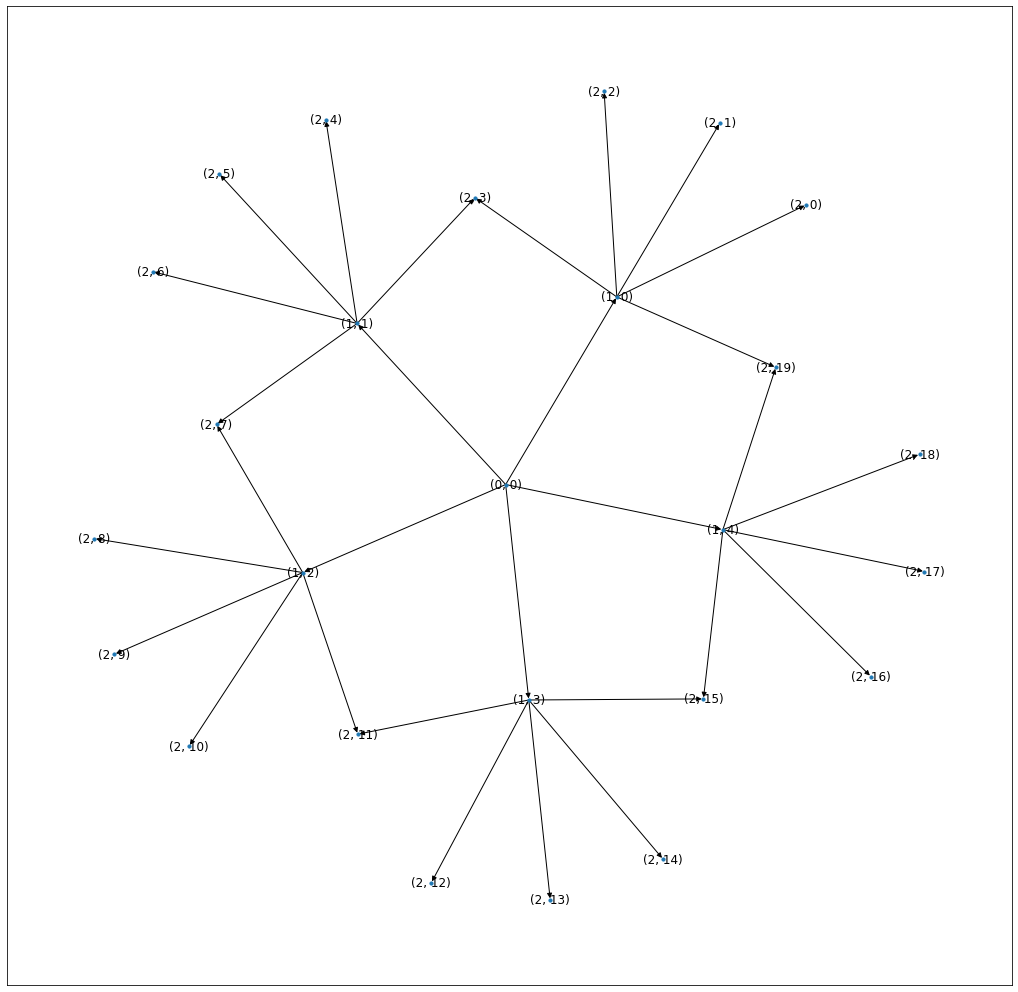

In [82]:
plot_graph(G, labels=True)

With this code, we can createt hyperbolic graphs that have different degrees per ring.

In [83]:
G = hyperbolic_network(3, [5,5,5,5])

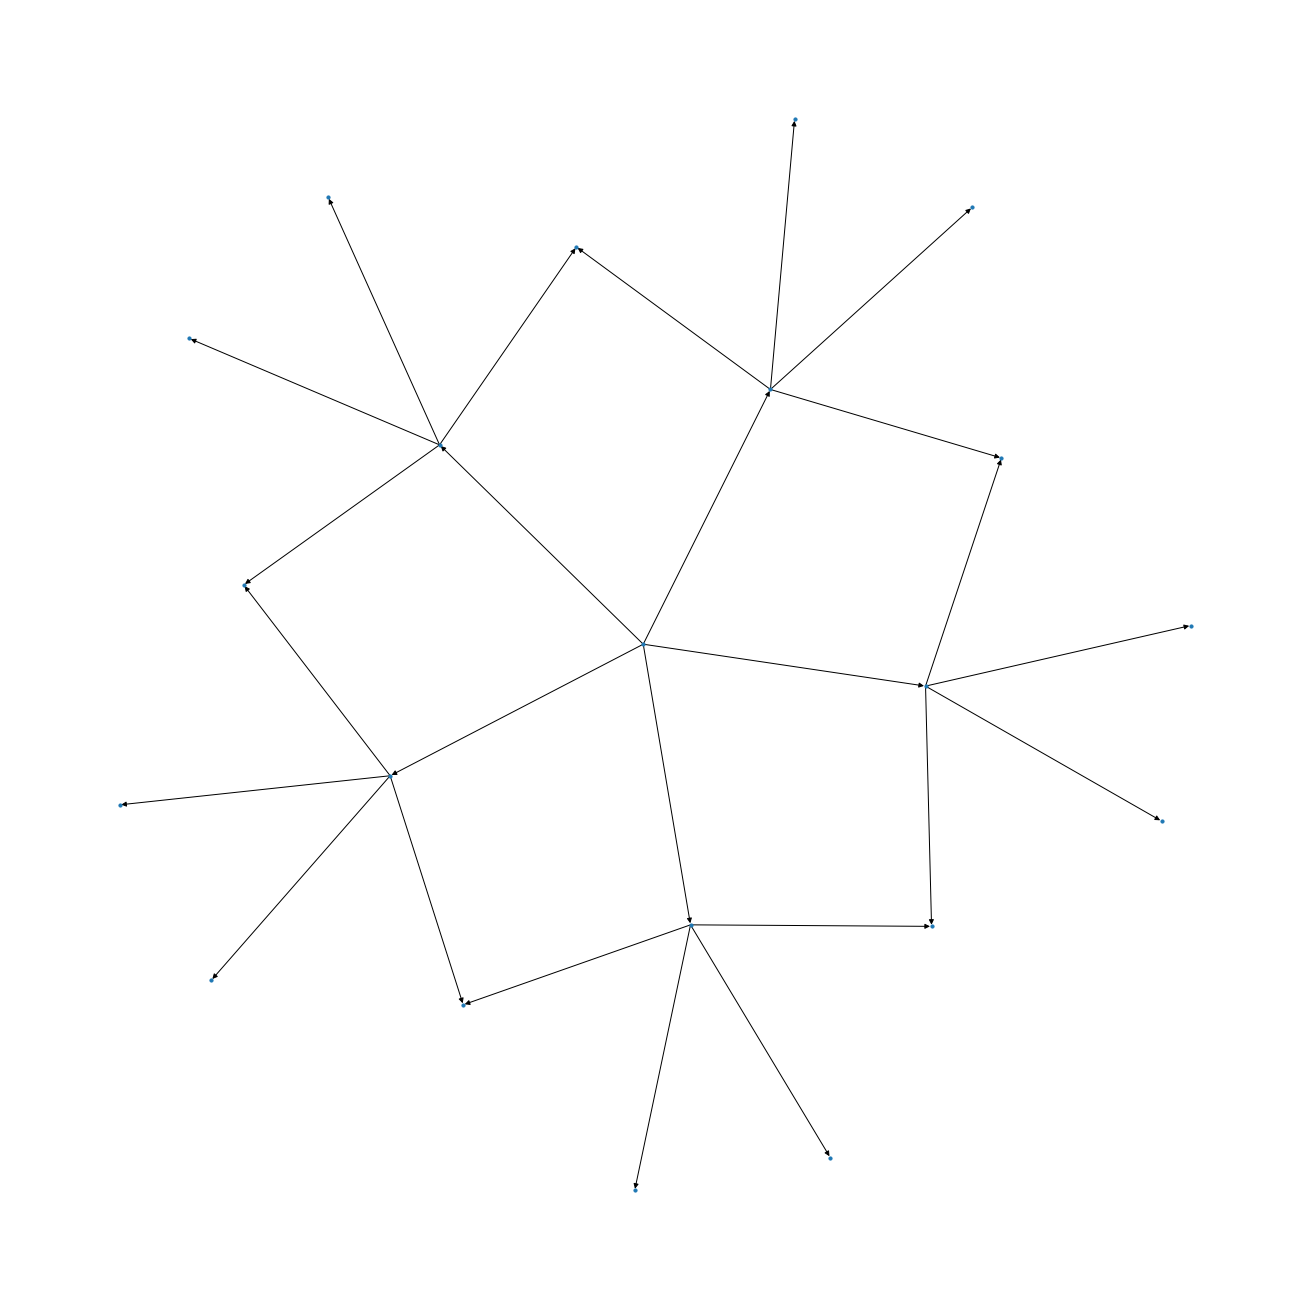

In [84]:
plot_graph(G)

These can get pretty big.

In [85]:
G = hyperbolic_network(5, [5,6,6,6,6,6])

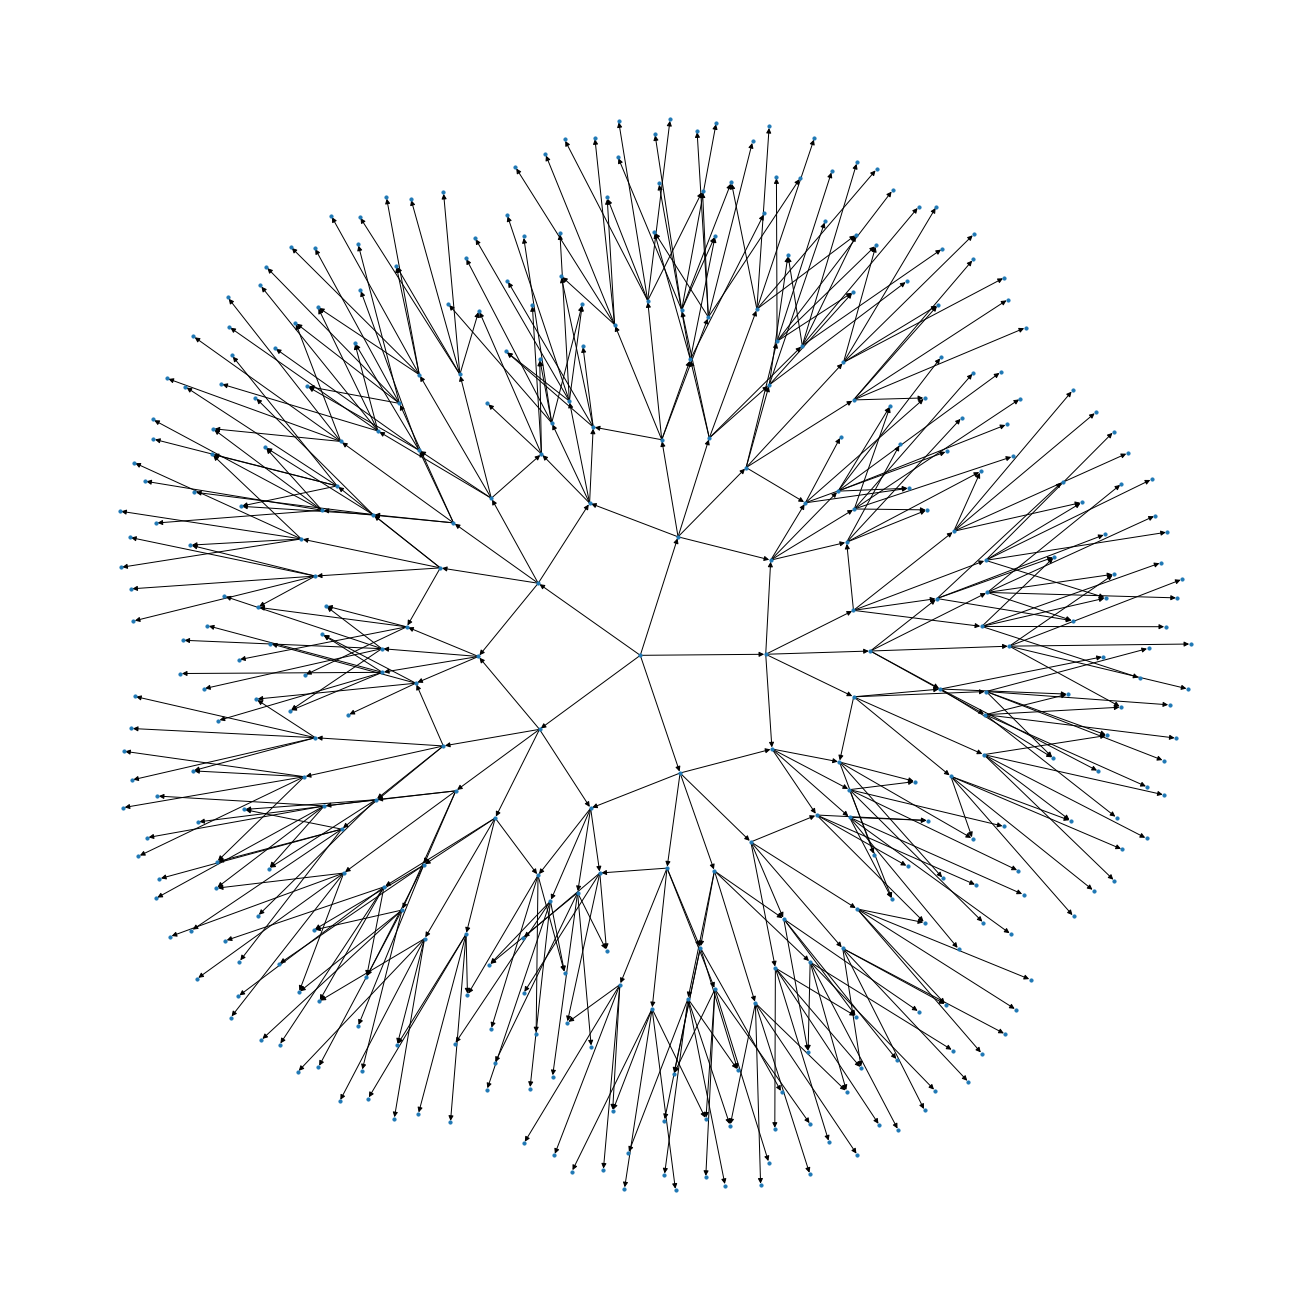

In [86]:
plot_graph(G)

We want to leave one code per node, and then compose all the codes into one. The strategy we are going to follow is to take a pair of codes next to each other and compose them. In terms of the graph, this means the two corresponding ndoes are merged with each other. 

Note that since all the edges are going from level $i$ to level $i+1$, this is a Directed Acyclic graph (DAG). This will help us to contract this to a single, big, stabilizer code. 

Note that if htis were not a DAG, hte composiiotn would not make sense. So we must keep the graph a DAG as we contract it. To do so, we start contracting from the outmost vertices. These are given by the last vertices in the topological order.

In [87]:
def contract_graph(G, plot_contractions=False, ignore_check:bool = False):
    """Contracts the graph and returns the order of the qubits and the resulting code."""
    aux = G.copy()
    ts = list(nx.topological_sort(aux))

    for idx, n in enumerate(ts):
        aux.nodes[n]["order"] = idx

    ts = ts[1:]
    if plot_contractions:
        plot_graph(aux, figsize=(6, 6), labels=True)

    for a in tqdm(ts[::-1]):
        # Get the last vertex topologically

        # Get the last vertex topologically among the ones that have edges towards a
        incoming = list(x[0] for x in aux.in_edges(a))
        highest = max(incoming, key=lambda x: aux.nodes[x]["order"])

        # Get the multiplicity fo the reduction
        multiplicity = aux.number_of_edges(highest, a)

        # Contract the graph
        aux = nx.contracted_edge(aux, (highest, a), self_loops=False)

        # Get the codes to compose, before and after.
        codeHighest = aux.nodes[highest]["code"]
        codeA = aux.nodes[highest]["contraction"][a]["code"]

        # get the set of physical qubits corresponding to each vertex
        physHighest = aux.nodes[highest]["physical"]
        physA = aux.nodes[highest]["contraction"][a]["physical"]

        # By construction, the None's in the physical qubits will always be at the start
        none_idxs = list(range(multiplicity))

        # Get the composed code
        Composed = compose_stabilizer_codes(codeHighest, codeA, none_idxs, none_idxs, ignore_check = ignore_check)

        new_phys = physHighest[multiplicity:] + physA

        # Delete the information of the deleted qubit
        # And update the information of the qubit
        del aux.nodes[highest]["contraction"]
        aux.nodes[highest]["physical"] = new_phys
        aux.nodes[highest]["code"] = Composed

        if plot_contractions:
            plot_graph(aux, figsize=(6, 6), labels=True)
            plt.show()

    physical_qubits_order = aux.nodes[(0, 0)]["physical"]
    code = aux.nodes[(0, 0)]["code"]
    return physical_qubits_order, code

In [88]:
G = hyperbolic_network(3, [5,6,6,6,6,6,6])
fill_graph(G)

Here we can see how the graph evolves as we contract it.

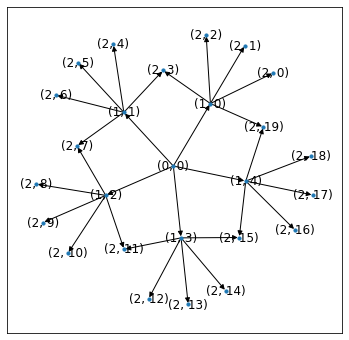

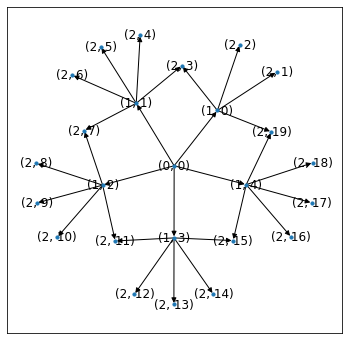

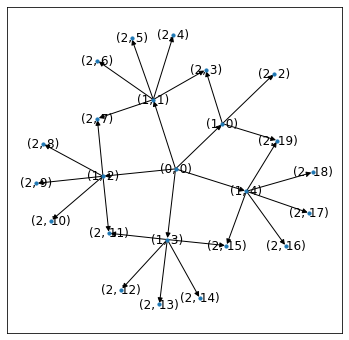

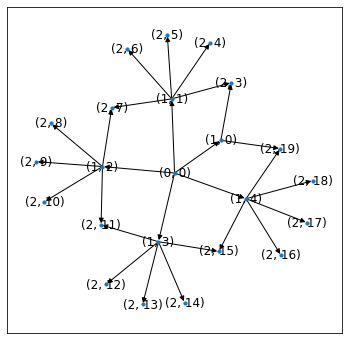

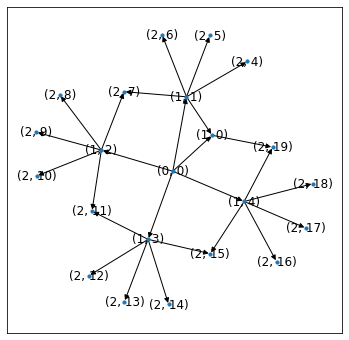

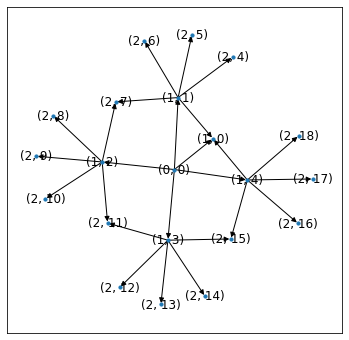

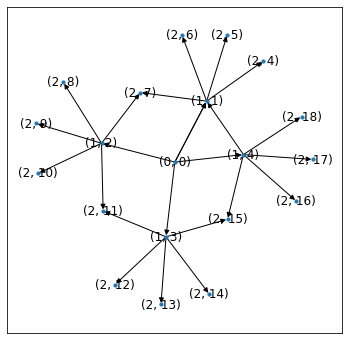

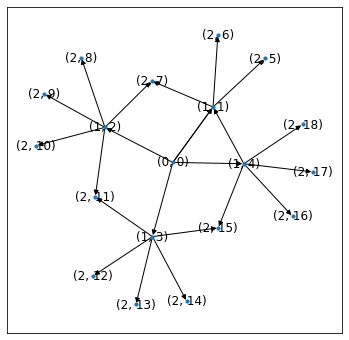

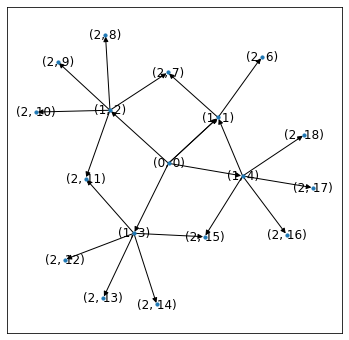

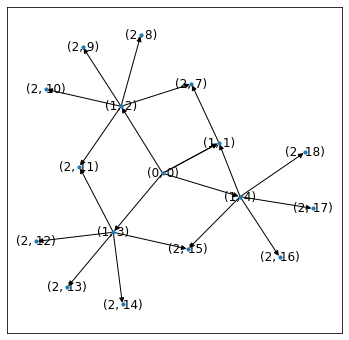

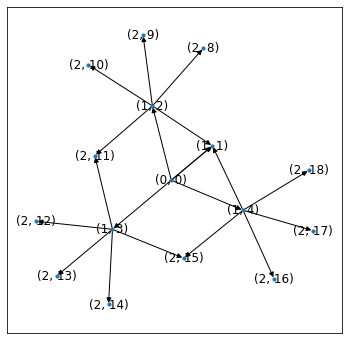

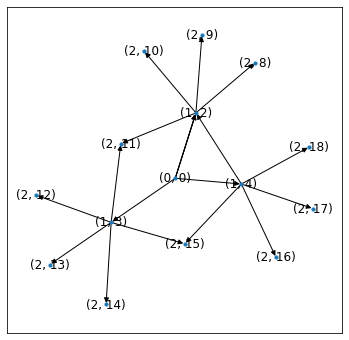

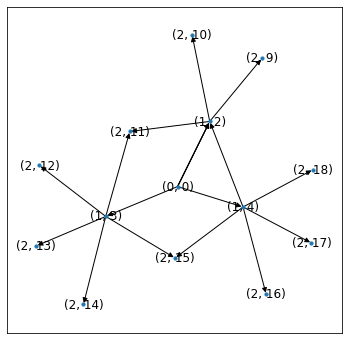

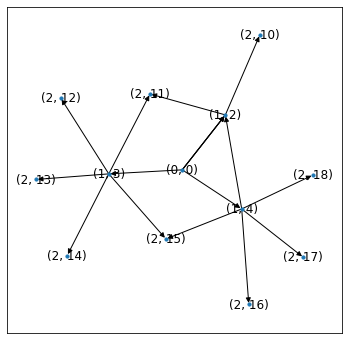

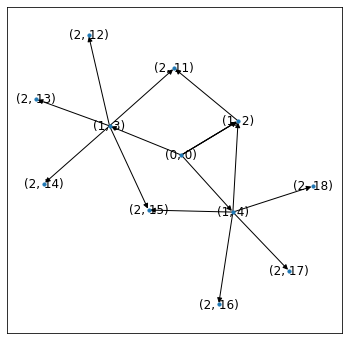

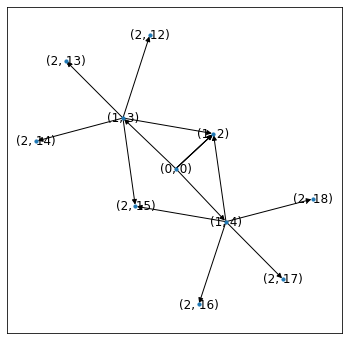

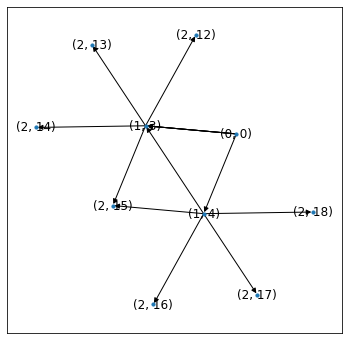

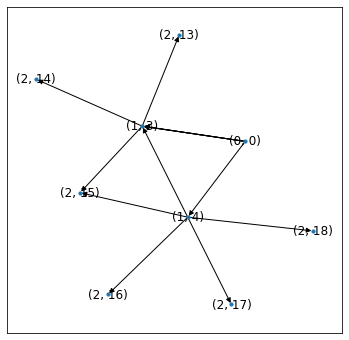

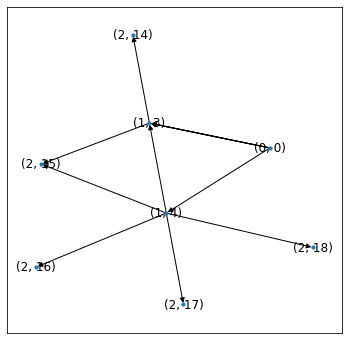

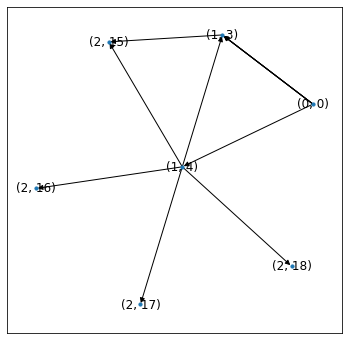

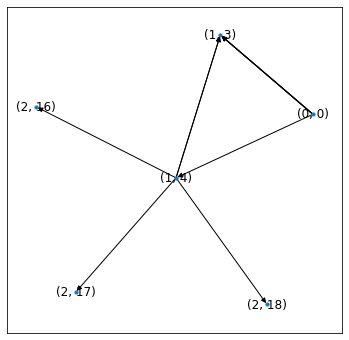

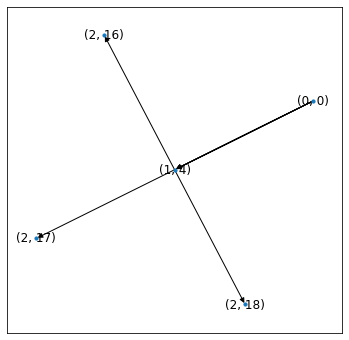

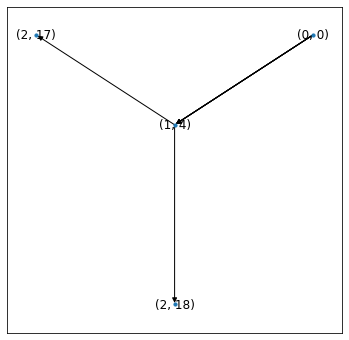

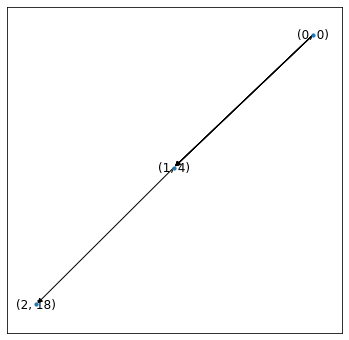

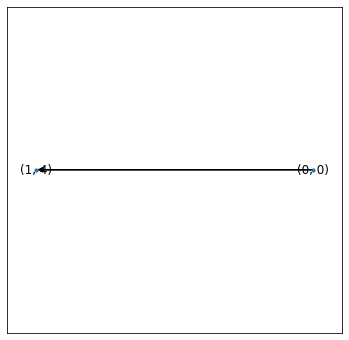

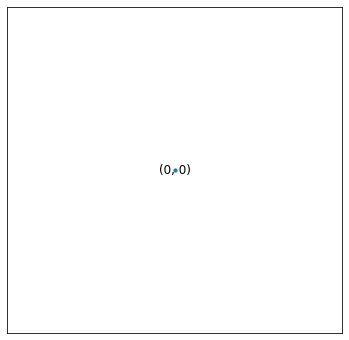

In [89]:
phys, code = contract_graph(G, plot_contractions=True)

We kept track of what physical qubit corresponds to what qubit in the stabilizer code. Note that these are not in order.

In [90]:
phys

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 91,
 92,
 93,
 94,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90]

In [91]:
physical_to_stabilizer = {p: i for i, p in enumerate(phys)}
physical_to_stabilizer

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 91: 19,
 92: 20,
 93: 21,
 94: 22,
 19: 23,
 20: 24,
 21: 25,
 22: 26,
 23: 27,
 24: 28,
 25: 29,
 26: 30,
 27: 31,
 28: 32,
 29: 33,
 30: 34,
 31: 35,
 32: 36,
 33: 37,
 34: 38,
 35: 39,
 36: 40,
 37: 41,
 38: 42,
 39: 43,
 40: 44,
 41: 45,
 42: 46,
 43: 47,
 44: 48,
 45: 49,
 46: 50,
 47: 51,
 48: 52,
 49: 53,
 50: 54,
 51: 55,
 52: 56,
 53: 57,
 54: 58,
 55: 59,
 56: 60,
 57: 61,
 58: 62,
 59: 63,
 60: 64,
 61: 65,
 62: 66,
 63: 67,
 64: 68,
 65: 69,
 66: 70,
 67: 71,
 68: 72,
 69: 73,
 70: 74,
 71: 75,
 72: 76,
 73: 77,
 74: 78,
 75: 79,
 76: 80,
 77: 81,
 78: 82,
 79: 83,
 80: 84,
 81: 85,
 82: 86,
 83: 87,
 84: 88,
 85: 89,
 86: 90,
 87: 91,
 88: 92,
 89: 93,
 90: 94}

Now that we have the code, we can try checking if it can correct a single error in an known location. If all the syndromes are distinct, then the errors are all correctible. 

Of course, this is not a requirement, since two errors $E$ and $F$ might have the same syndrome because they differ by an element of $\cS$, htat is, $E = SF$ for smoe $S\in \cS$.

In [92]:
def single_error_in_qubits(qubits_idx, n):
    all_errors = []
    for q in qubits_idx:
        for c in "XZ":
            base = ["I"] * n
            base[q] = c
            all_errors.append(PauliNElement("".join(base)))
    return all_errors

In [93]:
one_qubit_syndromes = set()
for E in single_error_in_qubits(range(code.physical_n_qubits), code.physical_n_qubits):
    one_qubit_syndromes.add(tuple(code.get_syndrome_op(E)))

In [94]:
# We see that the number of syndromes is hte one we expect.
len(one_qubit_syndromes) == 2 * code.physical_n_qubits

True

In [95]:
#We can see the code is, well, big
code

StabilizerCode(generators=[PauliNElement(components='XXXXXXXXXXXXXXXXXXXXZIIXXXXXXXXXXXXXXXXZIIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXYYIXXXXXXXXXXXXXXXX', phase=2), PauliNElement(components='ZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZXYYZZZZZZZZZZZZZZZIYZYZZZZZZZZZZZZZZZZXYYZZZZZZZZZZZZZZZ', phase=2), PauliNElement(components='ZZZZZZZZZZZZZZZZZZZZXYYZZZZZZZZZZZZZZZIYZYZZZZZZZZZZZZZZZZXYYZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ', phase=2), PauliNElement(components='XXXXXXXXXXXXXXXXXXXYYIXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXZIIXXXXXXXXXXXXXXXXZIIXXXXXXXXXXXXXXX', phase=2), PauliNElement(components='XXXXXXXXXXXXXXXXZIIYYIXXXXXXXXXXXXXXXXYYIXXXXXXXXXXXXXXXXYYIXXXXXXXXXXXXXXXXYYIXZZZZZXXXXXIIIII', phase=2), PauliNElement(components='ZZZZZZZZZZZZZZZZZZZIYZYZZZZZZZZZZZZZZZIYZYZZZZZZZZZZZZZZZIYZYZZZZZZZZZZZZZZZIYZYXXXXXIIIIIXXXXX', phase=0), PauliNElement(components='ZZZZZZZZZZZZZZZZXYYIYZYZZZZZZZZZZZZZZZIYZYZZZZZZZZZZZZZZZIYZYZZZZZZZZZZZZZZZIYZYIIIIIXXXXXZZZZZ', phase=0), PauliNElement(components='XXXXXXXXX

In [96]:
codeReduced = code.to_reduced_form()

So we can correct any one error, without know it's location. This is not very surprising, since the $5$-qubit code can do the same.

To do a more general check, we need to actually check that errors are either outside the normalizer or inside the stabilizer. We will check now that this is an actual situation that happens.

To be more precise, we will confirm that just checking that syndromes are distinct will incorrectly give you that correctible errors are no correcible.


In [97]:
def make_error_array(code, qubits_idx):
    return np.array(
        [code.get_syndrome_op(E) for E in single_error_in_qubits(qubits_idx, code.physical_n_qubits)]
    ).astype(bool)

In [98]:
def rank_mod2(arr):
    x = arr.copy().astype(bool)
    current_rank = 0
    for i in range(x.shape[1]):
#         breakpoint()
        if np.sum(x[current_rank:, i]) == 0:
            continue

        j = current_rank
        while not x[j, i]:
            j += 1

        # x[j, i] is True
        x[[current_rank, j]] = x[[j, current_rank]]
        
        for j in range(current_rank + 1, x.shape[0]):
            if x[j, i]:
                x[j] = x[j] ^ x[current_rank]
        current_rank += 1
        if current_rank == x.shape[0]:
            break
    return current_rank
        

In [99]:
arr = make_error_array(
    code, [physical_to_stabilizer[0], physical_to_stabilizer[1]]
).astype(bool)

In [100]:
rank_mod2(arr)

4

The (wrong) test will be to check that the binary matrix created from the syndromes has rank equal to the number of errors.

In [101]:
def wrong_errors_can_be_corrected(code, qubits_idx):
    return rank_mod2(make_error_array(code, qubits_idx)) == 2 * len(qubits_idx)

We will see that this will (incorrectly) tell us that we can't erase the first four qubits. However, erasing the first four physical qubits is equal to erasing one qubit one level up, which is correctible! So we should be acually fine.

In [102]:
def wrong_correctible_qubits_consecutively(code, physical_to_stabilizer, debug=False):
    qubits_idx = []
    for i in range(0, code.physical_n_qubits):
        qubits_idx.append(physical_to_stabilizer[i])

        is_good_code = wrong_errors_can_be_corrected(code, qubits_idx)

        if not is_good_code:
            qubits_idx = qubits_idx[:-1]
            break
    return qubits_idx

wrong_correctible_qubits_consecutively(code, physical_to_stabilizer)

[0, 1, 2]

More precisely, we consider the error consisting of $XZZX$ at the beginning. Again, by the argument above, this should be correctible. However, we see that this is in the normalizer since the syndrome is all $0$.

In [103]:
e = PauliNElement(components='XZZXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', phase=0) 
all(i == 0 for i in code.get_syndrome_op(e))

True

In [104]:
all(i == 0 for i in codeReduced.get_syndrome_op(e))

True

In [105]:
codeReduced.in_stabilizer_group(e)

True

We see that it is actually in the stabilizer group! This makes our job more difficult, since we have to resort to testing every combination.

In [106]:
def all_errors_in_qubits(qubits_idx, n):
    all_errors = []
    for q in product("IXZY", repeat=len(qubits_idx)):
        base = ["I"] * n
        for c, idx in zip(q, qubits_idx):
            base[idx] = c
            
        yield PauliNElement("".join(base))

And we can see that all the errors in the first $4$ physical qubits are detectable.

In [107]:
qubits_idxs = list(map(lambda x: physical_to_stabilizer[x], [0, 1, 2, 3]))

list(
    filter(
        lambda x: not (codeReduced.is_detectable(x)),
        tqdm(all_errors_in_qubits(qubits_idxs, 95), total = 4**len(qubits_idxs)),
    )
)

[]

However, trying to test anything longer is exponentially harder. Testing $10$ qubits will require testing for $4^{10}=1048576$ options.

In [108]:
qubits_idxs = list(map(lambda x: physical_to_stabilizer[x], range(10)))

# The next computation will take too long, skipping it
if False:
    list(
        filter(
            lambda x: not (codeReduced.is_detectable(x)),
            tqdm(all_errors_in_qubits(qubits_idxs, 95), total = 4**len(qubits_idxs)),
        )
    )

This would be simple to confirm under the geometric picture of the stabilizer code. There is something important about the geometry here.

An alternative is to start from the exterior of the graph and check which internal qubits become corrupted.

In [109]:
def is_qubit_set_correctible(G, qubit_idx):
    last_level = [n for n in G if G.out_degree(n) == 0]
    level_idx = last_level[0][0]
    
    qubit_idx_set = set(qubit_idx) 
    
    next_erased = []
    for n in last_level:

        remaining_qubits = set(G.nodes[n]['physical']) - qubit_idx_set
        n_erased = len(G.nodes[n]['physical']) - len(remaining_qubits)

        if n_erased >= G.nodes[n]['code'].distance:
            next_erased.append(n)
            
    
    for level in range(level_idx, 0, -1):
        erased = next_erased
        next_erased = []

        counting_problems = Counter()
        
        for n in erased:
            p = list(G.predecessors(n))[0]
            counting_problems[p] += 1
        
        for n in counting_problems:
            if counting_problems[n] >= G.nodes[n]['code'].distance:
                next_erased.append(n)
    
    center_erased = (0,0) in next_erased
    
    return (not center_erased)
        

In [110]:
is_qubit_set_correctible(G, list(range(10)))

True

In [111]:
is_qubit_set_correctible(G, list(range(95)))

False

Now we can check the smallest consecutive qubits such that deleting will delete the center.

In [114]:
min_dist = 95
for i in range(95):
    for d in range(1, 96):
        qubit_range = list(range(i, i + d))
        qubit_range = list(map(lambda x: x % 95, qubit_range))
        
        corr = is_qubit_set_correctible(G, qubit_range)
        if not corr:
            dist = d
            break
    min_dist = min(min_dist, dist)
min_dist

44

So we can erase any $43$ consecutive qubits and things would be fine.